<a href="https://colab.research.google.com/github/wesley-db/Image-Stitching/blob/main/Image_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 50.8MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 62.4MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [ ]:
#Given Helper Functions
def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [ ]:
############ MY HELPER FUNCTION I - HOMOGRAPHY ##############
def find_homography_ransac(src, dest, threshold=0.35, max_iterations=1100):
  """
  Run RANSAC to estimate H.
  Input:
  - src, dest: coordinates
  - threshold: threshold for RANSAC
  - max_iterations: number of iterations for RANSAC
  Output:
  - estimated homography H
  - inliers
  """
  ind = np.random.choice(src.shape[0], size=4, replace=False)
  best_H = est_homography(src[ind], dest[ind])
  best_inliers = get_H_inliers(src[ind], dest[ind], best_H, threshold)
  inliers_num = best_inliers.shape[0]

  for i in range(max_iterations):
    ind = np.random.choice(src.shape[0], size=4, replace=False)
    H = est_homography(src[ind], dest[ind])
    inliers = get_H_inliers(src[ind], dest[ind], H, threshold)
    if inliers.shape[0] > inliers_num:
      #print(i)
      best_H = H
      best_inliers = inliers
      inliers_num = inliers.size

  return best_H, best_inliers

def get_H_inliers(pts1, pts2, H, thresh):
  """
  Computing the indexes of the inliers
  Inputs:
  - pts1: This is the 'true' coordinates
  - pts2: This is the coordinates, which H would be applied at.
  - thresh: threshold of the difference
  - H: the homography that relates pts2 with pts1
  Output:
  - The indexes of the inliers
  """
  #Applying homography
  est_pts = apply_homography(H,pts1)

  #Calculating L2 distance between pts1 and est_pts
  x_diff2 = np.square(pts2[::,0] - est_pts[::,0])
  y_diff2 = np.square(pts2[::,1] - est_pts[::,1])
  delta = np.sqrt(x_diff2 + y_diff2)

  return np.where(delta < thresh)[0]

def calculate_matches(src, tgt, thresh=0.5):
  """
  The function produces the mask of indexes, where desc1 and desc2 are a good match.
  The is a modified code from openCV tutotrial.
  Inputs:
  - src: the sift feature of the source image
  - tgt: the sift feature of the target image
  - thresh: threshold for Lowe's ratio test
  Output:
  - The mask of interest
  """
  #Finding NBB using FLANN
  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50) # or pass empty dictionary

  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(src,tgt,k=2)

  #Conducting Lowe's ratio
  nbb1 = np.array([[m.queryIdx,m.trainIdx] for (m,n) in matches])
  dist = np.array([[m.distance, n.distance] for (m,n) in matches])
  ratio = dist[::,0] < thresh*dist[::,1]
  answ = nbb1[np.where(ratio==True)[0]]

  return answ[::,0], answ[::,1]

In [ ]:
############ MY HELPER FUNCTION II - CROPING ##############
def crop_darkspots(img, edges_warp):
  """
  Crop the dark spots of an image resulting from warping
  Its assumed that the right image image is warped to match the left one.
  It will throw an error when the warped image is bad (eg.it's flipped after warping)
  Input:
  - img: A combination of two images
  - edges_warp: The location of all four edges of the right image of the panorama after warping
  Output:
  - The desired image
  """
  #edges = np.array(top_left(x,y), top_right(x,y), bottom_left(x,y), bottom_right(x,y))
  x_warp, y_warp = edges_warp[::,0].astype(int), edges_warp[::,1].astype(int)

  x_max = x_warp[1] if x_warp[1] < x_warp[3] else x_warp[3]
  if (x_max > img.shape[1]): x_max = img.shape[1]
  x_min = x_warp[0] if x_warp[0] > x_warp[2] else x_warp[2]

  y_max = y_warp[2] if y_warp[2] < y_warp[3] else y_warp[3]
  if (y_max > img.shape[0]): y_max = img.shape[0]
  y_min = y_warp[0] if y_warp[0] > y_warp[1] else y_warp[1]
  if (y_min < 0): y_min = 0

  if (y_max <= y_min or x_max <= 0 or x_max <= x_min):
    raise Exception('The homography matrix is bad. Please try again.')

  return img[y_min:y_max, :x_max, ::]

In [ ]:
############ MY HELPER FUNCTION III - SMOOTHING ##############
def pyramidsGL(image, num_levels):
  '''
  Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im.
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively.
  Input:
  - image: The source image
  - num_levels: The max level of the pyramid
  Output:
  - The 2 desired pyramids
  """
  '''
  G = [image]
  image_a = image
  for i in range(num_levels-1):
    #blur
    image_b = cv2.GaussianBlur(image_a,(21,21),0)
    #downsample
    image_b = cv2.resize(image_b, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
    #adding
    G.append(image_b)
    #prep for the next
    image_a = image_b
  ###########################
  L = []
  for i in range(0,num_levels-1):
    image_a = G[i]
    #upscale
    ds = image_a.shape
    image_b = cv2.resize(G[i+1], (ds[1],ds[0]), interpolation=cv2.INTER_NEAREST)
    #blur
    image_b = cv2.GaussianBlur(image_b,(21,21),0)
    #adding
    result = image_a - image_b
    L.append(result)
  L.append(G[num_levels-1])

  return G, L

def pyramid_blend(L_l, L_r, G_w):
  """
  It performs a pyramid blending on thhe images on the 2 Laplacian pyramids
  with G_w as the weight to determine the ratio to blend the two.
  Input:
  - L_l: The laplacian pyramid of the left image
  - L_r: The laplacian pyramid of the right imgae
  - G_w: A gaussian pyramid that serves as a weight.
  Output:
  - A blended image of the left and right images.
  """
  #Blending
  blended = []
  for l,r,w in zip(L_l,L_r,G_w):
    left = l * w
    right = r * (1.0 - w)
    blended.append( left + right )
  #Reconstruction
  img = blended[-1]
  for i in range(len(blended)-2,-1,-1):
    ds_curr = blended[i].shape
    img = cv2.resize(img, (ds_curr[1],ds_curr[0]), interpolation=cv2.INTER_NEAREST)
    img = cv2.GaussianBlur(img,(21,21),0)
    img = blended[i] + img

  return img

In [ ]:
############ MY HELPER FUNCTION IV - STITCHING ##############
def stitch_images(img1, img2):
  """
  Stitch two images at a time.
  Inputs:
  - img1, img2 with shape [H, W, 3].
  Output:
  - stitched_image with shape [H, W, 3].
  """
  #1. Detect keypoints
  gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(gray1,None)
  pts1 = cv2.KeyPoint_convert(kp1)
  kp2, des2 = sift.detectAndCompute(gray2,None)
  pts2 = cv2.KeyPoint_convert(kp2)

  #2. Match keypoints
  if des1 is None or des2 is None:
    raise Exception('No similarities found between the 2 images. Please try again.')
  src_mask, tgt_mask = calculate_matches(des1,des2)
  pts1_matches = pts1[src_mask]
  pts2_matches = pts2[tgt_mask]

  #3. Estimate homography with matched keypoints (using RANSAC)
  H, inliers = find_homography_ransac(pts1_matches,pts2_matches)
  #print(H/H[2,2])

  #4. Combine images
    #image adjustments
  ds1 = img1.shape
  ds2 = img2.shape
  img_r = cv2.warpPerspective(img2, H, dsize=(ds1[1]+ds2[1],ds1[0]),\
                              flags=cv2.WARP_INVERSE_MAP).astype(np.float64)

  ds_r = img_r.shape
  img_l = np.append(img1, np.zeros((ds_r[0],ds_r[1]-ds1[1],3)), 1)

    #blend & combine
  edges = np.array([ [0,0],[ds2[1],0],[0,ds2[0]],[ds2[1],ds2[0]] ])
  edges_warp = apply_homography(np.linalg.pinv(H), edges)
  x_warp = edges_warp[::,0].astype(int)
  y_warp = edges_warp[::,1].astype(int)

  weight = np.zeros(ds_r)
  min_edge_x = x_warp[0] if x_warp[0] < x_warp[2] else x_warp[2]
  weight[::,:min_edge_x+(ds1[1]-min_edge_x)//2] = 1

  max_level = int( np.floor(np.log2( min(ds_r[0],ds_r[1]) )) )
  _, L_r = pyramidsGL(img_r, max_level)
  _, L_l = pyramidsGL(img_l, max_level)
  G_w,_ = pyramidsGL(weight, max_level)

  fin = crop_darkspots(pyramid_blend(L_l,L_r,G_w), edges_warp)

  return cv2.convertScaleAbs(fin)

# Main Function

['/content/tv/1.jpg', '/content/tv/2.jpg', '/content/tv/3.jpg']


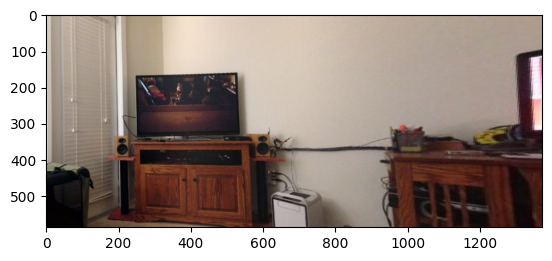

In [ ]:
img_path = '/content/tv'
img_list = sorted(glob.glob(os.path.join(img_path, "*.JPG"))) \
          + sorted(glob.glob(os.path.join(img_path, "*.jpg")))

print(img_list)
panorama = cv2.imread(img_list[0])
panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

for i in range(1,len(img_list)):
  next_img = cv2.imread(img_list[i])
  next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2RGB)
  panorama = stitch_images(panorama, next_img)

plt.imshow(panorama)
plt.show()